<a href="https://colab.research.google.com/github/INIT-FIU-Hardware-Build-Spring2024/ASL-Glove/blob/main/version1_everything.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Classes: ['ILoveYou' 'Paws_Up']
Number of classes: 2

Performing 5-fold cross-validation:

Random Forest Cross-Validation Results:
Fold Accuracies: [1. 1. 1. 1. 1.]
Mean Accuracy: 1.0000
Std Deviation: 0.0000

Top 10 Important Features (Random Forest):
  Feature  Importance
1      F2    0.550121
0      F1    0.223717
7       Z    0.065973
2      F3    0.050830
4      F5    0.047829
3      F4    0.027866
6       Y    0.019852
5       X    0.013811

SVM Cross-Validation Results:
Fold Accuracies: [1. 1. 1. 1. 1.]
Mean Accuracy: 1.0000
Std Deviation: 0.0000

Detailed Evaluation on Test Set:
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

    ILoveYou       1.00      1.00      1.00        24
     Paws_Up       1.00      1.00      1.00        24

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48



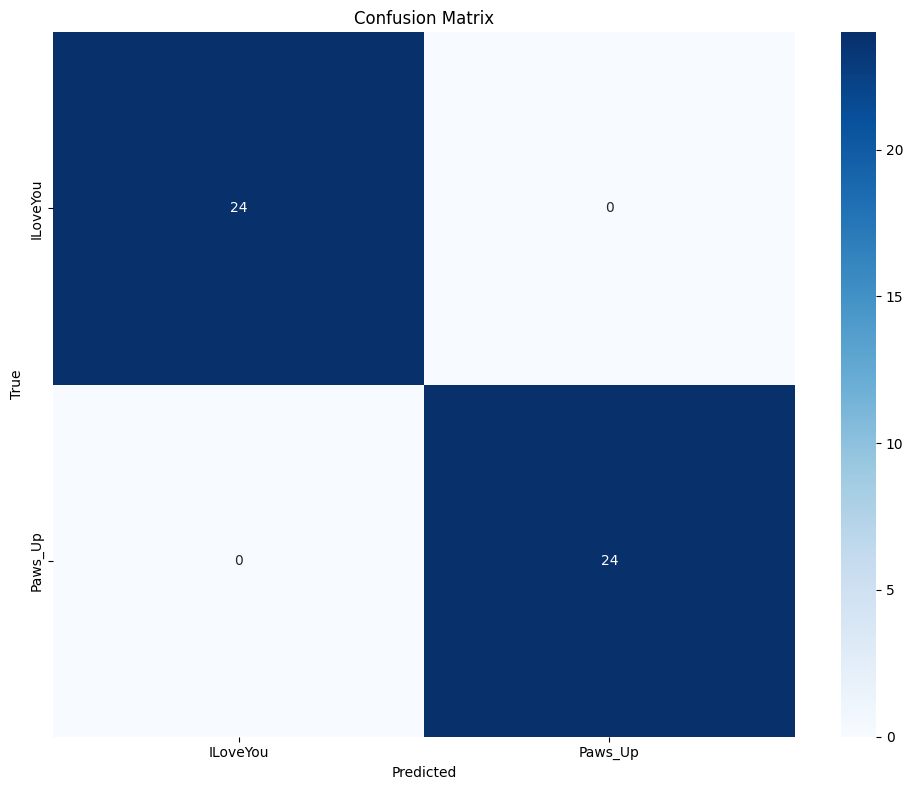


Tree 1 Rules:
|--- X <= 0.75
|   |--- F5 <= 0.46
|   |   |--- F2 <= 0.26
|   |   |   |--- class: 0.0
|   |   |--- F2 >  0.26
|   |   |   |--- class: 1.0
|   |--- F5 >  0.46
|   |   |--- class: 1.0
|--- X >  0.75
|   |--- Z <= 0.71
|   |   |--- F2 <= 0.31
|   |   |   |--- class: 0.0
|   |   |--- F2 >  0.31
|   |   |   |--- class: 1.0
|   |--- Z >  0.71
|   |   |--- F2 <= 0.43
|   |   |   |--- class: 0.0
|   |   |--- F2 >  0.43
|   |   |   |--- class: 1.0


Tree 2 Rules:
|--- Z <= 0.71
|   |--- F5 <= 0.65
|   |   |--- F1 <= 0.63
|   |   |   |--- class: 0.0
|   |   |--- F1 >  0.63
|   |   |   |--- class: 1.0
|   |--- F5 >  0.65
|   |   |--- F3 <= 0.80
|   |   |   |--- class: 0.0
|   |   |--- F3 >  0.80
|   |   |   |--- class: 1.0
|--- Z >  0.71
|   |--- F4 <= 0.85
|   |   |--- F2 <= 0.43
|   |   |   |--- class: 0.0
|   |   |--- F2 >  0.43
|   |   |   |--- class: 1.0
|   |--- F4 >  0.85
|   |   |--- class: 1.0


Tree 3 Rules:
|--- F5 <= 0.71
|   |--- X <= 0.81
|   |   |--- Y <= 0.31
|   |

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

#-Added from GPT #1 4/10/25 7:49PM
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_text



# Code to train neural network





#--------------------------------------------------------
# 1. Load the Data
#--------------------------------------------------------
# csv1 = "sensors_data_1.csv"
# csv2 = "sensors_data_2.csv"
csv1 = "ILoveYou_data_Normalized.csv"
csv2 = "Paws_Up_data_Normalized.csv"

#normalized data
#df1 = pd.read_csv("csv1")
#df2 = pd.read_csv("csv2")


#Non-normalized/raw data
df1 = pd.read_csv("ILoveYou_data.csv")
df2 = pd.read_csv("Paws_Up_data.csv")
df = pd.concat([df1, df2], ignore_index=True)

# Combine the two dataframes
all_data = [df1, df2]

#--------------------------------------------------------
# 2. Clean and Preprocess Each DataFrame
#--------------------------------------------------------
for i, df in enumerate(all_data):
    for col in df.columns:
        if col != "Gesture":
            # Convert to numeric if needed
            df[col] = pd.to_numeric(df[col], errors='coerce')
            # Replace NaNs with median
            df[col] = df[col].fillna(df[col].median())
    all_data[i] = df

# Concatenate all the data
df = pd.concat(all_data, ignore_index=True)

# Final check for non-numeric values in features
for col in df.columns:
    if col != "Gesture" and not pd.api.types.is_numeric_dtype(df[col]):
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df[col] = df[col].fillna(df[col].median())

# Drop rows where Gesture is missing
df = df.dropna(subset=["Gesture"])

#--------------------------------------------------------
# 3. Feature & Label Separation
#--------------------------------------------------------
X = df.drop("Gesture", axis=1).astype(np.float32)
y = df["Gesture"]

# Encode the labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
print(f"Classes: {encoder.classes_}")
print(f"Number of classes: {len(encoder.classes_)}")

# Scale the features

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X).astype(np.float32)

#--------------------------------------------------------
# 4. Define Models
#--------------------------------------------------------
models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        random_state=42
    ),
    "SVM": SVC(
        kernel='rbf',
        C=1.0,
        gamma='scale',
        random_state=42
    )
}

#--------------------------------------------------------
# 5. Cross-Validation
#--------------------------------------------------------
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

print(f"\nPerforming {n_folds}-fold cross-validation:")
for name, model in models.items():
    cv_scores = cross_val_score(model, X_scaled, y_encoded, cv=skf, scoring='accuracy')

    print(f"\n{name} Cross-Validation Results:")
    print(f"Fold Accuracies: {cv_scores}")
    print(f"Mean Accuracy: {cv_scores.mean():.4f}")
    print(f"Std Deviation: {cv_scores.std():.4f}")

    model.fit(X_scaled, y_encoded)

    if name == "Random Forest":
        feat_importance_df = pd.DataFrame({
            'Feature': X.columns,
            'Importance': model.feature_importances_
        }).sort_values(by='Importance', ascending=False)

        print("\nTop 10 Important Features (Random Forest):")
        print(feat_importance_df.head(10))

#--------------------------------------------------------
# 6. Train-Test Split Evaluation
#--------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Use best model from CV (adjust based on CV results)
best_model = models["SVM"]
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Evaluation Metrics
print("\nDetailed Evaluation on Test Set:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

#shows the Random forest Model as a tree
rf = RandomForestClassifier(
    n_estimators=3,    # Small number of trees
    max_depth=3,       # Keep trees shallow
    random_state=42
)
rf.fit(X_scaled, y_encoded)
for i, estimator in enumerate(rf.estimators_):
    print(f"\nTree {i + 1} Rules:")
    tree_rules = export_text(estimator, feature_names=list(X.columns))
    print(tree_rules)

# ---------------------------------------------------------------
# Train the final Random Forest model to be used in deployment
# ---------------------------------------------------------------
# We use a small Random Forest (n_estimators=3) with shallow depth (max_depth=3)
# because this will later be used in a real-time interpreter (e.g., on PC (Visual Stuidio)).
#
# - Fewer trees and shallower depth make the model easier to visualize, export, and run fast.
# - The model is trained on scaled float32 input (X_scaled) and integer-encoded gesture labels (y_encoded).
# - This is the model that gets saved as "gesture_model.pkl" and used in the Python interpreter
#   to recognize gestures in real-time.
#
# ⚠️ Important: Do not confuse this with the 'rf' model above used only for printing tree rules.
# This rf_small model is the official trained model for use during runtime.
# Save the correct model
rf_small = RandomForestClassifier(n_estimators=3, max_depth=3, random_state=42)
rf_small.fit(X_scaled.astype(np.float32), y_encoded)

# Save trained classifier
joblib.dump(rf_small, "gesture_model.pkl")

# Save the LabelEncoder
joblib.dump(encoder, "label_encoder.pkl")

# Save the Scaler
joblib.dump(scaler, "scaler.pkl")

#debug checks
print(X.dtypes)
print(type(X_scaled))  # should be <class 'numpy.ndarray'>
print(X_scaled.dtype)  # should say float32
print("Tree dtype:", rf_small.estimators_[0].tree_.threshold.dtype)




Classes: ['Dale' 'ILoveYou' 'Paws_Up']
Number of classes: 3

Performing 5-fold cross-validation:

Random Forest Cross-Validation Results:
Fold Accuracies: [1. 1. 1. 1. 1.]
Mean Accuracy: 1.0000
Std Deviation: 0.0000

Top 10 Important Features (Random Forest):
  Feature  Importance
1      F2    0.331167
0      F1    0.186756
4      F5    0.182187
2      F3    0.111865
5       X    0.067225
3      F4    0.056704
6       Y    0.033015
7       Z    0.031080

SVM Cross-Validation Results:
Fold Accuracies: [1.         0.94444444 0.95833333 0.97222222 0.97222222]
Mean Accuracy: 0.9694
Std Deviation: 0.0184

Detailed Evaluation on Test Set:
Accuracy: 0.9861

Classification Report:
              precision    recall  f1-score   support

        Dale       1.00      0.96      0.98        24
    ILoveYou       0.96      1.00      0.98        24
     Paws_Up       1.00      1.00      1.00        24

    accuracy                           0.99        72
   macro avg       0.99      0.99      0.99   

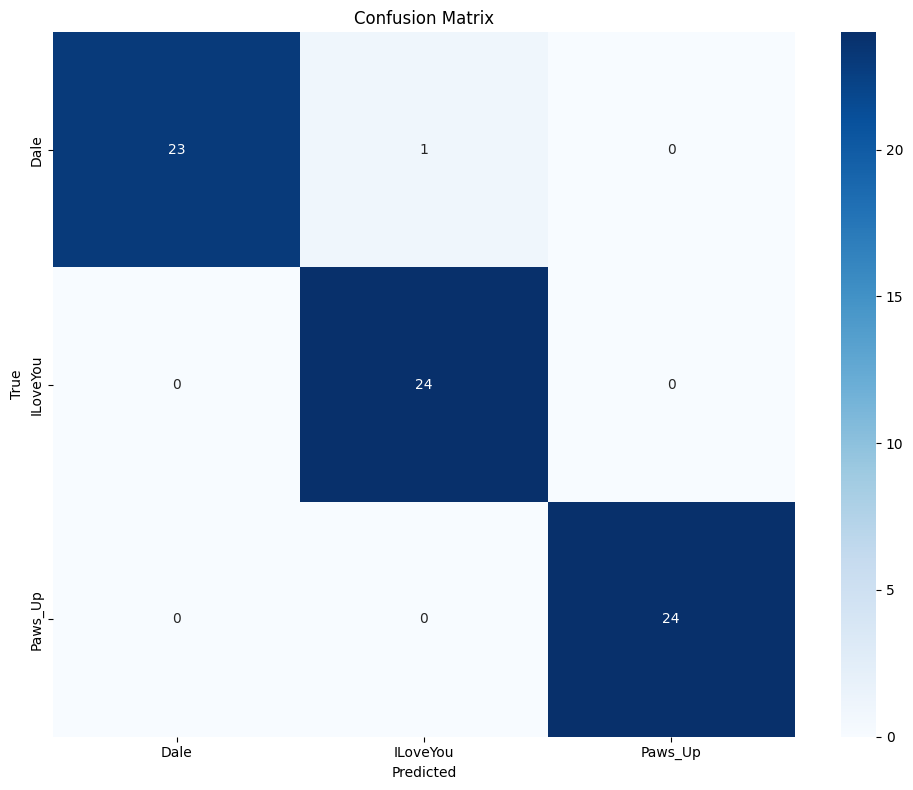


Tree 1 Rules:
|--- X <= 0.90
|   |--- F5 <= 0.64
|   |   |--- F2 <= 0.29
|   |   |   |--- class: 1.0
|   |   |--- F2 >  0.29
|   |   |   |--- class: 2.0
|   |--- F5 >  0.64
|   |   |--- X <= 0.83
|   |   |   |--- class: 1.0
|   |   |--- X >  0.83
|   |   |   |--- class: 0.0
|--- X >  0.90
|   |--- F2 <= 0.84
|   |   |--- F1 <= 0.70
|   |   |   |--- class: 0.0
|   |   |--- F1 >  0.70
|   |   |   |--- class: 2.0
|   |--- F2 >  0.84
|   |   |--- Y <= 0.72
|   |   |   |--- class: 0.0
|   |   |--- Y >  0.72
|   |   |   |--- class: 2.0


Tree 2 Rules:
|--- F3 <= 0.67
|   |--- F4 <= 0.47
|   |   |--- F5 <= 0.67
|   |   |   |--- class: 1.0
|   |   |--- F5 >  0.67
|   |   |   |--- class: 0.0
|   |--- F4 >  0.47
|   |   |--- F3 <= 0.51
|   |   |   |--- class: 1.0
|   |   |--- F3 >  0.51
|   |   |   |--- class: 0.0
|--- F3 >  0.67
|   |--- F3 <= 0.89
|   |   |--- F2 <= 0.36
|   |   |   |--- class: 1.0
|   |   |--- F2 >  0.36
|   |   |   |--- class: 2.0
|   |--- F3 >  0.89
|   |   |--- F4 <= 0.91

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

#-Added from GPT #1 4/10/25 7:49PM
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_text



# Code to train neural network





#--------------------------------------------------------
# 1. Load the Data
#--------------------------------------------------------
# csv1 = "sensors_data_1.csv"
# csv2 = "sensors_data_2.csv"
csv1 = "ILoveYou_data.csv"
csv2 = "Paws_Up_data.csv"
csv3 = "Dale_data.csv"

#normalized data
#df1 = pd.read_csv("csv1")
#df2 = pd.read_csv("csv2")


#Non-normalized/raw data
df1 = pd.read_csv("ILoveYou_data.csv")
df2 = pd.read_csv("Paws_Up_data.csv")
df3 = pd.read_csv("Dale_data.csv")
df = pd.concat([df1, df2, df3], ignore_index=True)

# Combine the two dataframes
all_data = [df1, df2, df3]

#--------------------------------------------------------
# 2. Clean and Preprocess Each DataFrame
#--------------------------------------------------------
for i, df in enumerate(all_data):
    for col in df.columns:
        if col != "Gesture":
            # Convert to numeric if needed
            df[col] = pd.to_numeric(df[col], errors='coerce')
            # Replace NaNs with median
            df[col] = df[col].fillna(df[col].median())
    all_data[i] = df

# Concatenate all the data
df = pd.concat(all_data, ignore_index=True)

# Final check for non-numeric values in features
for col in df.columns:
    if col != "Gesture" and not pd.api.types.is_numeric_dtype(df[col]):
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df[col] = df[col].fillna(df[col].median())

# Drop rows where Gesture is missing
df = df.dropna(subset=["Gesture"])

#--------------------------------------------------------
# 3. Feature & Label Separation
#--------------------------------------------------------
X = df.drop("Gesture", axis=1).astype(np.float32)
y = df["Gesture"]

# Encode the labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
print(f"Classes: {encoder.classes_}")
print(f"Number of classes: {len(encoder.classes_)}")

# Scale the features

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X).astype(np.float32)

#--------------------------------------------------------
# 4. Define Models
#--------------------------------------------------------
models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        random_state=42
    ),
    "SVM": SVC(
        kernel='rbf',
        C=1.0,
        gamma='scale',
        random_state=42
    )
}

#--------------------------------------------------------
# 5. Cross-Validation
#--------------------------------------------------------
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

print(f"\nPerforming {n_folds}-fold cross-validation:")
for name, model in models.items():
    cv_scores = cross_val_score(model, X_scaled, y_encoded, cv=skf, scoring='accuracy')

    print(f"\n{name} Cross-Validation Results:")
    print(f"Fold Accuracies: {cv_scores}")
    print(f"Mean Accuracy: {cv_scores.mean():.4f}")
    print(f"Std Deviation: {cv_scores.std():.4f}")

    model.fit(X_scaled, y_encoded)

    if name == "Random Forest":
        feat_importance_df = pd.DataFrame({
            'Feature': X.columns,
            'Importance': model.feature_importances_
        }).sort_values(by='Importance', ascending=False)

        print("\nTop 10 Important Features (Random Forest):")
        print(feat_importance_df.head(10))

#--------------------------------------------------------
# 6. Train-Test Split Evaluation
#--------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Use best model from CV (adjust based on CV results)
best_model = models["SVM"]
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Evaluation Metrics
print("\nDetailed Evaluation on Test Set:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

#shows the Random forest Model as a tree
rf = RandomForestClassifier(
    n_estimators=3,    # Small number of trees
    max_depth=3,       # Keep trees shallow
    random_state=42
)
rf.fit(X_scaled, y_encoded)
for i, estimator in enumerate(rf.estimators_):
    print(f"\nTree {i + 1} Rules:")
    tree_rules = export_text(estimator, feature_names=list(X.columns))
    print(tree_rules)

# ---------------------------------------------------------------
# Train the final Random Forest model to be used in deployment
# ---------------------------------------------------------------
# We use a small Random Forest (n_estimators=3) with shallow depth (max_depth=3)
# because this will later be used in a real-time interpreter (e.g., on PC (Visual Stuidio)).
#
# - Fewer trees and shallower depth make the model easier to visualize, export, and run fast.
# - The model is trained on scaled float32 input (X_scaled) and integer-encoded gesture labels (y_encoded).
# - This is the model that gets saved as "gesture_model.pkl" and used in the Python interpreter
#   to recognize gestures in real-time.
#
# ⚠️ Important: Do not confuse this with the 'rf' model above used only for printing tree rules.
# This rf_small model is the official trained model for use during runtime.
# Save the correct model
rf_small = RandomForestClassifier(n_estimators=3, max_depth=3, random_state=42)
rf_small.fit(X_scaled.astype(np.float32), y_encoded)

# Save trained classifier
joblib.dump(rf_small, "gesture_model.pkl")

# Save the LabelEncoder
joblib.dump(encoder, "label_encoder.pkl")

# Save the Scaler
joblib.dump(scaler, "scaler.pkl")

#debug checks
print(X.dtypes)
print(type(X_scaled))  # should be <class 'numpy.ndarray'>
print(X_scaled.dtype)  # should say float32
print("Tree dtype:", rf_small.estimators_[0].tree_.threshold.dtype)
